<a href="https://colab.research.google.com/github/PhiDung-hub/Intro_to_TF2/blob/main/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [ ]:
import tensorflow as tf
from scipy.io import loadmat
print('tf.ver: ', tf.__version__, '\t CUDA compatibile: ', tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

tf.ver:  2.5.0 	 CUDA compatibile:  True
[]


For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. You should store these files in Drive for use in this Colab notebook.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [ ]:
# # Run this cell to connect to your Drive folder

# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# Load the dataset from your Drive folder

train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder as oh

In [ ]:
train['X'].shape, test['X'].shape, train['y'].shape, test['y'].shape

((32, 32, 3, 73257), (32, 32, 3, 26032), (73257, 1), (26032, 1))

In [ ]:
# PREPROCESSING CELL

# move last axis of input to first
X_train, X_test = np.moveaxis(train['X'], -1, 0) / 255, np.moveaxis(test['X'], -1, 0) / 255

# one-hot encoding the categorical output
y_train = tf.keras.utils.to_categorical(train['y'] - 1, num_classes=10)
y_test = tf.keras.utils.to_categorical(test['y'] - 1, num_classes=10)

In [ ]:
# All data have been correctly reshaped.
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((73257, 32, 32, 3), (26032, 32, 32, 3), (73257, 10), (26032, 10))

In [ ]:
train['y'][1]

array([9], dtype=uint8)

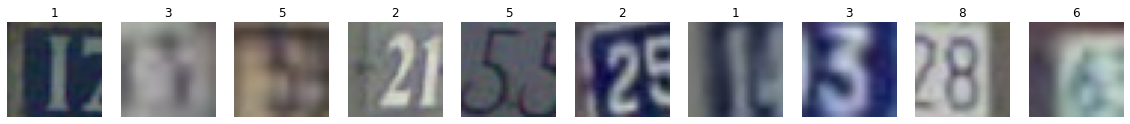

In [ ]:
def show_img(data=X_train, cmap='viridis', number=10, show_label=None):
    fig, ax = plt.subplots(1, 10, figsize=(20, 5))
    t=0
    # for i in np.random.choice(range(data.shape[0]), 10, replace=False):
    for i in np.random.choice(range(data.shape[0]), number, replace=False):
        ax[t].set_axis_off()

        if show_label is not None:
            print(f'Label {i}:  {show_label[i]}')
        ax[t].imshow(data[i, ...], cmap=cmap)
        ax[t].set_title(train['y'].reshape(-1)[i])
        t+=1

show_img()

In [ ]:
# Convert all data to gray_scale img

# X_train = np.add.reduce(X_train, axis=-1, keepdims=True) / 3
# X_test = np.add.reduce(X_test, axis=-1, keepdims=True) / 3
X_train = X_train.mean(axis = -1, keepdims=True)
X_test = X_test.mean(axis = -1, keepdims=True)

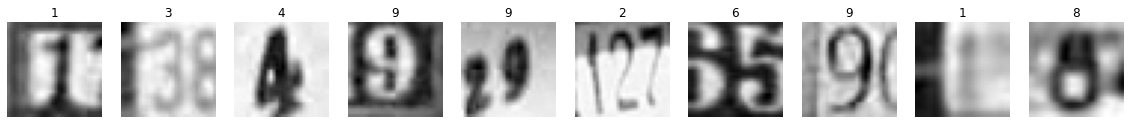

In [ ]:
show_img(data=X_train,cmap='gray')

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout, AveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [ ]:
from tensorflow.keras import regularizers, initializers

def get_mlp_model(input_shape=X_train[0].shape, output_features=10, lr=1e-3, l1=1e-3, l2=3e-2):
    # Network architecture. Since the network is 32*32=1024 -> 10. neurons should be around 1e3.
    # first layer use tanh to increase relu performances, though it is expensive.
    # excessive use of tanh can lead to vanishing gradient.
    model = Sequential([
        Flatten(input_shape=input_shape, name='Flatten'),
      #   BatchNormalization(),
        Dense(512, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2), 
              kernel_initializer='glorot_normal', bias_initializer=initializers.Zeros(), 
              activation='tanh', name='Dense_tanh1'),
      #   Dropout(.5), # DON'T use dropout with BatchNormalization.
      #   BatchNormalization(),
        Dense(256, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2),
              kernel_initializer='he_normal', bias_initializer=initializers.Zeros(),
              activation='relu', name='Dense_relu1'), 
      #   Dropout(.3), # DON'T use dropout with BatchNormalization.
        Dense(128, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2),
              kernel_initializer='he_uniform', bias_initializer=initializers.Zeros(), 
              activation='relu', name='Dense_relu2'),
      #   Dropout(.3), # DON'T use dropout with BatchNormalization.
      #   BatchNormalization(),
        Dense(64, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2),
              kernel_initializer='he_uniform', bias_initializer=initializers.Zeros(), 
              activation='relu', name='Dense_relu3'),

        Dense(output_features, activation='softmax', name='Dense_softmax')
    ])
    
    # compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(lr), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [ ]:
mlp_model = get_mlp_model(lr=1e-3, l1=0, l2=0)
mlp_model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
Dense_tanh1 (Dense)          (None, 512)               524800    
_________________________________________________________________
Dense_relu1 (Dense)          (None, 256)               131328    
_________________________________________________________________
Dense_relu2 (Dense)          (None, 128)               32896     
_________________________________________________________________
Dense_relu3 (Dense)          (None, 64)                8256      
_________________________________________________________________
Dense_softmax (Dense)        (None, 10)                650       
Total params: 697,930
Trainable params: 697,930
Non-trainable params: 0
_______________________________________________

In [ ]:
# return history of training data.
def train_model(model, net_type='MLP', epochs=30, val=.15, batch=128, 
                patience=1, lr_schedule=0, X_train=X_train, y_train=y_train,):
    
    # callbacks for adjusting the training process.
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=patience)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=lr_schedule)
    
    # callbacks for checkpoints
    checkpoint_model_path = net_type + '_best_model/checkpoint'
    checkpoint_model = ModelCheckpoint(filepath=checkpoint_model_path, save_freq='epoch', 
                                       monitor='val_accuracy', save_best_only=True, verbose=1)
    checkpoint_best_path = net_type + '_checkpoints_best/checkpoint'
    checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path, save_weights_only=True, save_freq='epoch', 
                                      monitor='val_accuracy', save_best_only=True, verbose=1)
    checkpoint_epoch_path = net_type + '_checkpoints_epoch/checkpoint_epoch{epoch:03d}'
    checkpoint_epoch = ModelCheckpoint(filepath=checkpoint_epoch_path, save_weights_only=True, save_freq='epoch', 
                                      monitor='val_accuracy', verbose=1)
    my_callbacks = [early_stopping, lr_scheduler, checkpoint_best, checkpoint_epoch, checkpoint_model]
    
    # training logs of the process
    history = model.fit(X_train, y_train, epochs=epochs, callbacks=[my_callbacks],
                       validation_split=val, batch_size=batch, verbose=1)
    
    return history

In [ ]:
history = {}
history['MLP'] = train_model(mlp_model, batch=64, epochs=30, patience=2)

Epoch 1/30
973/973 [==============================] - 6s 5ms/step - loss: 2.0957 - accuracy: 0.2406 - val_loss: 1.6711 - val_accuracy: 0.4176

Epoch 00001: val_accuracy improved from -inf to 0.41760, saving model to MLP_checkpoints_best\checkpoint

Epoch 00001: saving model to MLP_checkpoints_epoch\checkpoint_epoch001

Epoch 00001: val_accuracy improved from -inf to 0.41760, saving model to MLP_best_model\checkpoint
INFO:tensorflow:Assets written to: MLP_best_model\checkpoint\assets
INFO:tensorflow:Assets written to: MLP_best_model\checkpoint\assets
Epoch 2/30
973/973 [==============================] - 5s 6ms/step - loss: 1.4281 - accuracy: 0.5135 - val_loss: 1.3283 - val_accuracy: 0.5597

Epoch 00002: val_accuracy improved from 0.41760 to 0.55965, saving model to MLP_checkpoints_best\checkpoint

Epoch 00002: saving model to MLP_checkpoints_epoch\checkpoint_epoch002

Epoch 00002: val_accuracy improved from 0.41760 to 0.55965, saving model to MLP_best_model\checkpoint
INFO:tensorflow:As

In [ ]:
def plot_learning_curve(net_type='MLP'):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax[0].plot(history[net_type].history['loss'])
    ax[0].plot(history[net_type].history['val_loss'])
    ax[0].set_title(f'Loss vs. epochs ({net_type} model)')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Training', 'Validation'], loc='upper right')
    ax[1].plot(history[net_type].history['accuracy'])
    ax[1].plot(history[net_type].history['val_accuracy'])
    ax[1].set_title(f'Accuracy vs. epochs ({net_type} model)')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Training', 'Validation'], loc='upper right')
    fig.show()

<ipython-input-249-75d8544e6b18>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


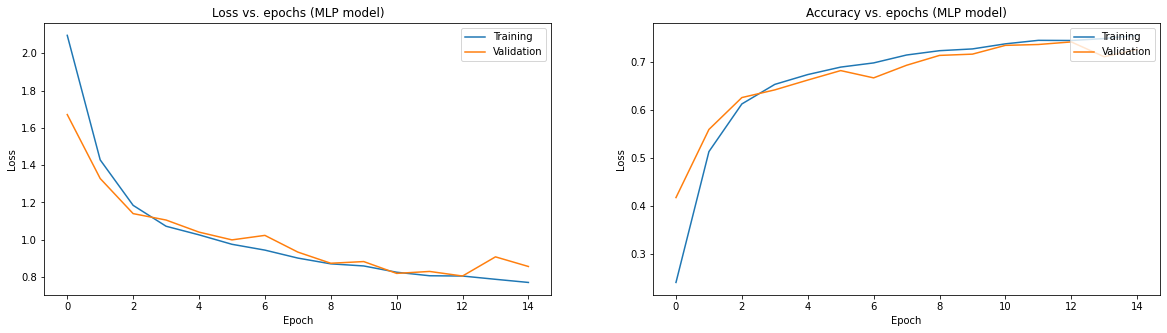

In [ ]:
plot_learning_curve()

In [ ]:
test_loss, test_acc = mlp_model.evaluate(X_test, y_test, verbose=0)
print("Test loss: {:.3f}\nTest accuracy: {:.2f}%".format(test_loss, 100 * test_acc))

Test loss: 0.958
Test accuracy: 70.23%


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [ ]:
def get_cnn_model(input_shape=X_train[0].shape, output_features=10, lr=1e-3, l1=1e-3, l2=3e-2):
    # Network architecture. Since the network is 32*32=1024 -> 10. neurons should be around 1e3.
    # 2 times 3x3 kernel = 5x5 kernel with better computation time
    model = Sequential([
        Conv2D(16, 3, input_shape=input_shape, activation = 'relu', padding='SAME', name='conv_1.1'), # 32x32x16 output
        Conv2D(16, 3, input_shape=input_shape, activation = 'relu', padding='SAME', name='conv_1.2'), # 32x32x16 output
        BatchNormalization(),
        MaxPool2D(2, name='maxpool_1'), # 16x16x16
        Conv2D(32, 3, activation = 'relu', padding='SAME', name='conv_2.1'), # 16x16x32 output
        Conv2D(32, 3, activation = 'relu', padding='SAME', name='conv_2.2'), # 16x16x32 output
        BatchNormalization(),
        MaxPool2D(2, name='maxpool_2'), # 8x8x32
        Conv2D(64, 3, activation = 'relu', padding='SAME', name='conv_3.1'), # 8x8x64 output
        Conv2D(64, 3, activation = 'relu', padding='SAME', name='conv_3.2'), # 8x8x64 output
        BatchNormalization(),
        MaxPool2D(2, name='maxpool_3'), # 4x4x64
        Conv2D(128, 3, activation = 'relu', padding='SAME', name='conv_4'), # 8x8x64 output
        BatchNormalization(),
        MaxPool2D(2, name='maxpool_4'), # 2x2x128
        Conv2D(64, 3, activation = 'relu', padding='SAME', name='conv_5'), # 8x8x64 output
        BatchNormalization(),
        MaxPool2D(2, name='maxpool_5'), # 2x2x128
        Dropout(.1),
        Conv2D(32, 1, name='conv_6'), # 2x2x32. Keep the best features
        Flatten(),
        Dense(64, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2),
              kernel_initializer='he_normal', bias_initializer=initializers.Zeros(), 
              activation='tanh', name='Dense_relu1'),
        Dense(output_features, activation='softmax', name='Dense_softmax')
    ])
    
    # compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(lr), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [ ]:
# Confident with large learning rate since we have BatchNormalization layer now.
cnn_model = get_cnn_model(lr=5e-3, l1=1e-5, l2=1e-5)
cnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1.1 (Conv2D)            (None, 32, 32, 16)        160       
_________________________________________________________________
conv_1.2 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
batch_normalization_28 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 16, 16, 16)        0         
_________________________________________________________________
conv_2.1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
conv_2.2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
batch_normalization_29 (Batc (None, 16, 16, 32)       

In [ ]:
history['CNN'] = train_model(cnn_model, net_type='CNN', batch=64, epochs=100, patience=3)

Epoch 1/100
973/973 [==============================] - 71s 72ms/step - loss: 1.2421 - accuracy: 0.5798 - val_loss: 0.7157 - val_accuracy: 0.7894

Epoch 00001: val_accuracy improved from -inf to 0.78943, saving model to CNN_checkpoints_best\checkpoint

Epoch 00001: saving model to CNN_checkpoints_epoch\checkpoint_epoch001

Epoch 00001: val_accuracy improved from -inf to 0.78943, saving model to CNN_best_model\checkpoint
INFO:tensorflow:Assets written to: CNN_best_model\checkpoint\assets
INFO:tensorflow:Assets written to: CNN_best_model\checkpoint\assets
Epoch 2/100
973/973 [==============================] - 74s 76ms/step - loss: 0.4729 - accuracy: 0.8594 - val_loss: 0.4669 - val_accuracy: 0.8579

Epoch 00002: val_accuracy improved from 0.78943 to 0.85795, saving model to CNN_checkpoints_best\checkpoint

Epoch 00002: saving model to CNN_checkpoints_epoch\checkpoint_epoch002

Epoch 00002: val_accuracy improved from 0.78943 to 0.85795, saving model to CNN_best_model\checkpoint
INFO:tensorf

In [ ]:
test_loss, test_acc = cnn_model.evaluate(X_test, y_test, verbose=2)
print("Test loss: {:.3f}\nTest accuracy: {:.2f}%".format(test_loss, 100 * test_acc))

814/814 - 10s - loss: 0.3155 - accuracy: 0.9148
Test loss: 0.316
Test accuracy: 91.48%


<ipython-input-30-75d8544e6b18>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


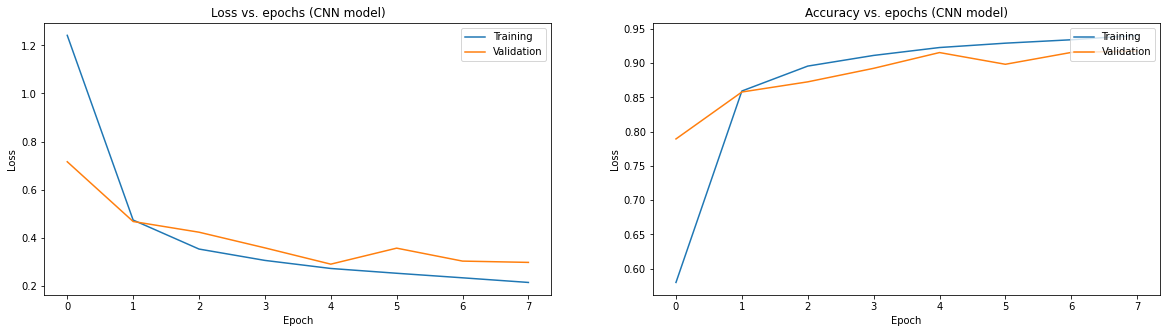

In [ ]:
plot_learning_curve('CNN')

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

### MLP Model

In [ ]:
path = tf.train.latest_checkpoint(checkpoint_dir='MLP_checkpoints_best')
best_mlp_model = get_mlp_model(l1=0, l2=0)
best_mlp_model.load_weights(path)

In [ ]:
test_loss, test_acc = best_mlp_model.evaluate(X_test, y_test, verbose=2)
print("Test loss: {:.3f}\nTest accuracy: {:.2f}%".format(test_loss, 100 * test_acc))

814/814 - 1s - loss: 0.8788 - accuracy: 0.7259
Test loss: 0.879
Test accuracy: 72.59%


In [ ]:
mlp_predictions = best_mlp_model.predict(X_test)

In [ ]:
# predicted number will be 1-based index of labels with max possibility. 

mlp_results = mlp_predictions.argmax(axis=1) + 1

<ipython-input-28-d1534f5b5d3a>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


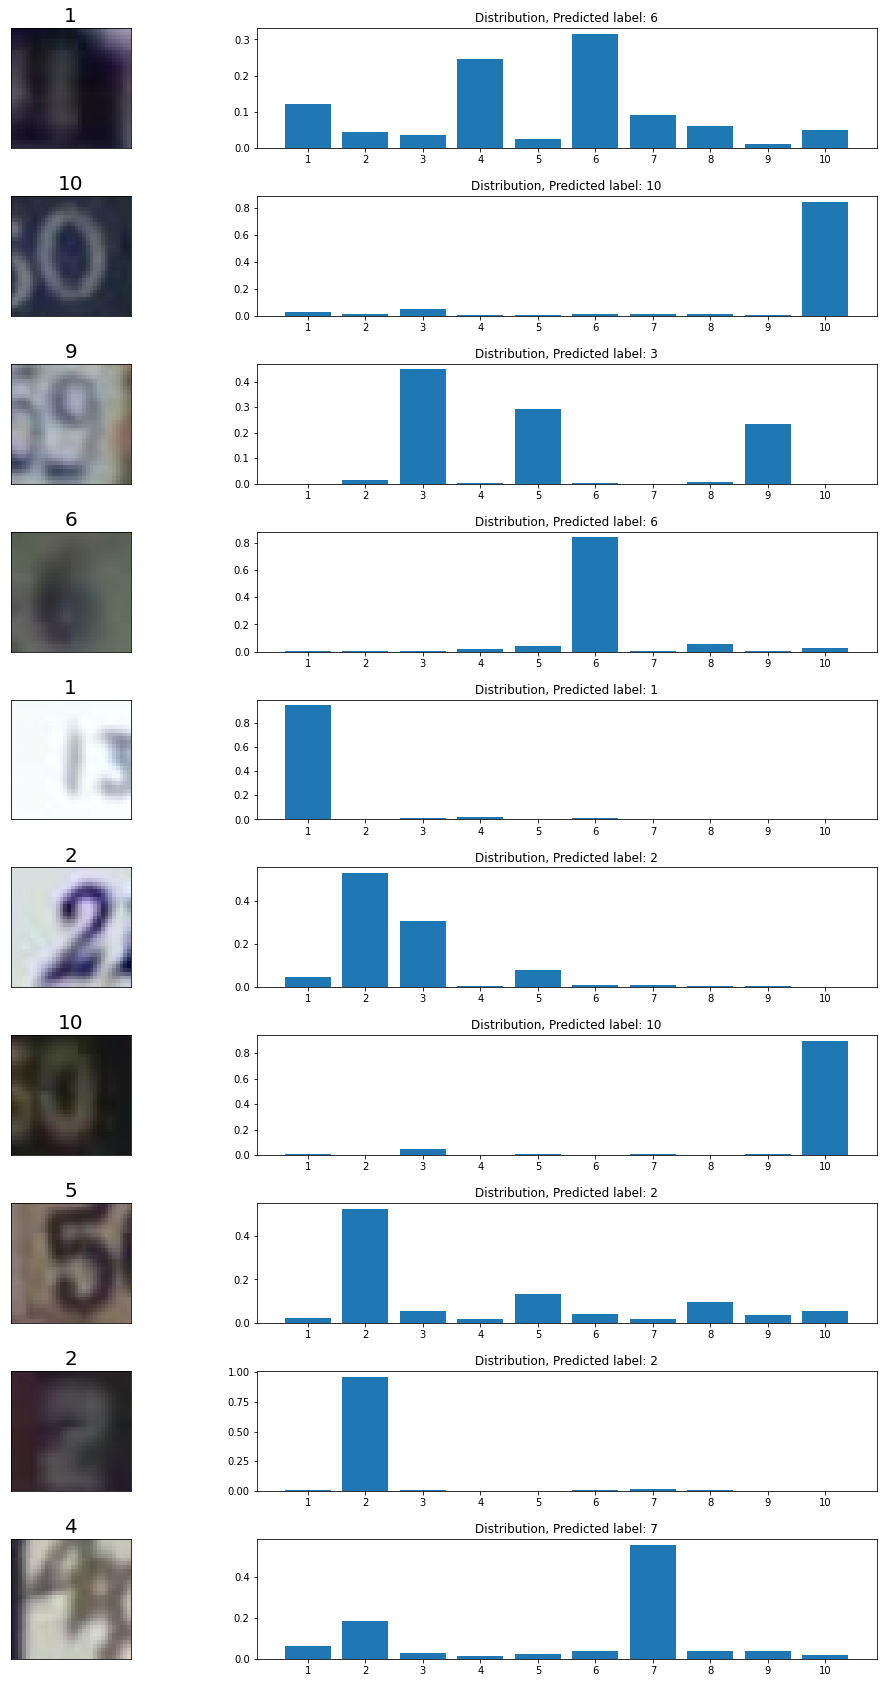

In [ ]:
def show_img_predictions(cmap='viridis', num=10, predictions='mlp'):
    fig, ax = plt.subplots(num, 2, figsize=(20, num*3))
    fig.subplots_adjust(hspace=0.4, wspace=-0.2)
    t=0
    for i in np.random.choice(range(test['X'].shape[-1]), num, replace=False):
        ax[t, 0].imshow(test['X'][..., i])
        ax[t, 0].get_xaxis().set_visible(False)
        ax[t, 0].get_yaxis().set_visible(False)
        ax[t, 0].set_title(test['y'].reshape(-1)[i], size=20)
        Distribution = eval(predictions+'_predictions')[i]
        Predicted_value = eval(predictions+'_results')[i]
        ax[t, 1].bar(x=np.arange(1, 11), height=Distribution,width=0.8)
        ax[t, 1].set_xticks(np.arange(1, 11))
        ax[t, 1].set_title(f"Distribution, Predicted label: {Predicted_value}")
        t+=1
    
    fig.show()

show_img_predictions(num=10)

<BarContainer object of 10 artists>

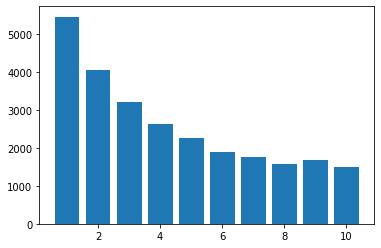

In [ ]:
# plot the bar chat distribution.
import collections
# get the distribution
mlp_dist = collections.Counter(mlp_results)

plt.bar(mlp_dist.keys(), mlp_dist.values(), align='center')

### CNN Model
* test_accuracy:
* epochs:

In [ ]:
path = tf.train.latest_checkpoint(checkpoint_dir='CNN_checkpoints_best')
best_cnn_model = get_cnn_model(l1=0, l2=0)
best_cnn_model.load_weights(path)

In [ ]:
test_loss, test_acc = best_cnn_model.evaluate(X_test, y_test, verbose=2)
print("Test loss: {:.3f}\nTest accuracy: {:.2f}%".format(test_loss, 100 * test_acc))

814/814 - 10s - loss: 0.3094 - accuracy: 0.9148
Test loss: 0.309
Test accuracy: 91.48%


In [ ]:
cnn_predictions = best_cnn_model.predict(X_test)
cnn_results = cnn_predictions.argmax(axis=1) + 1

<ipython-input-28-d1534f5b5d3a>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


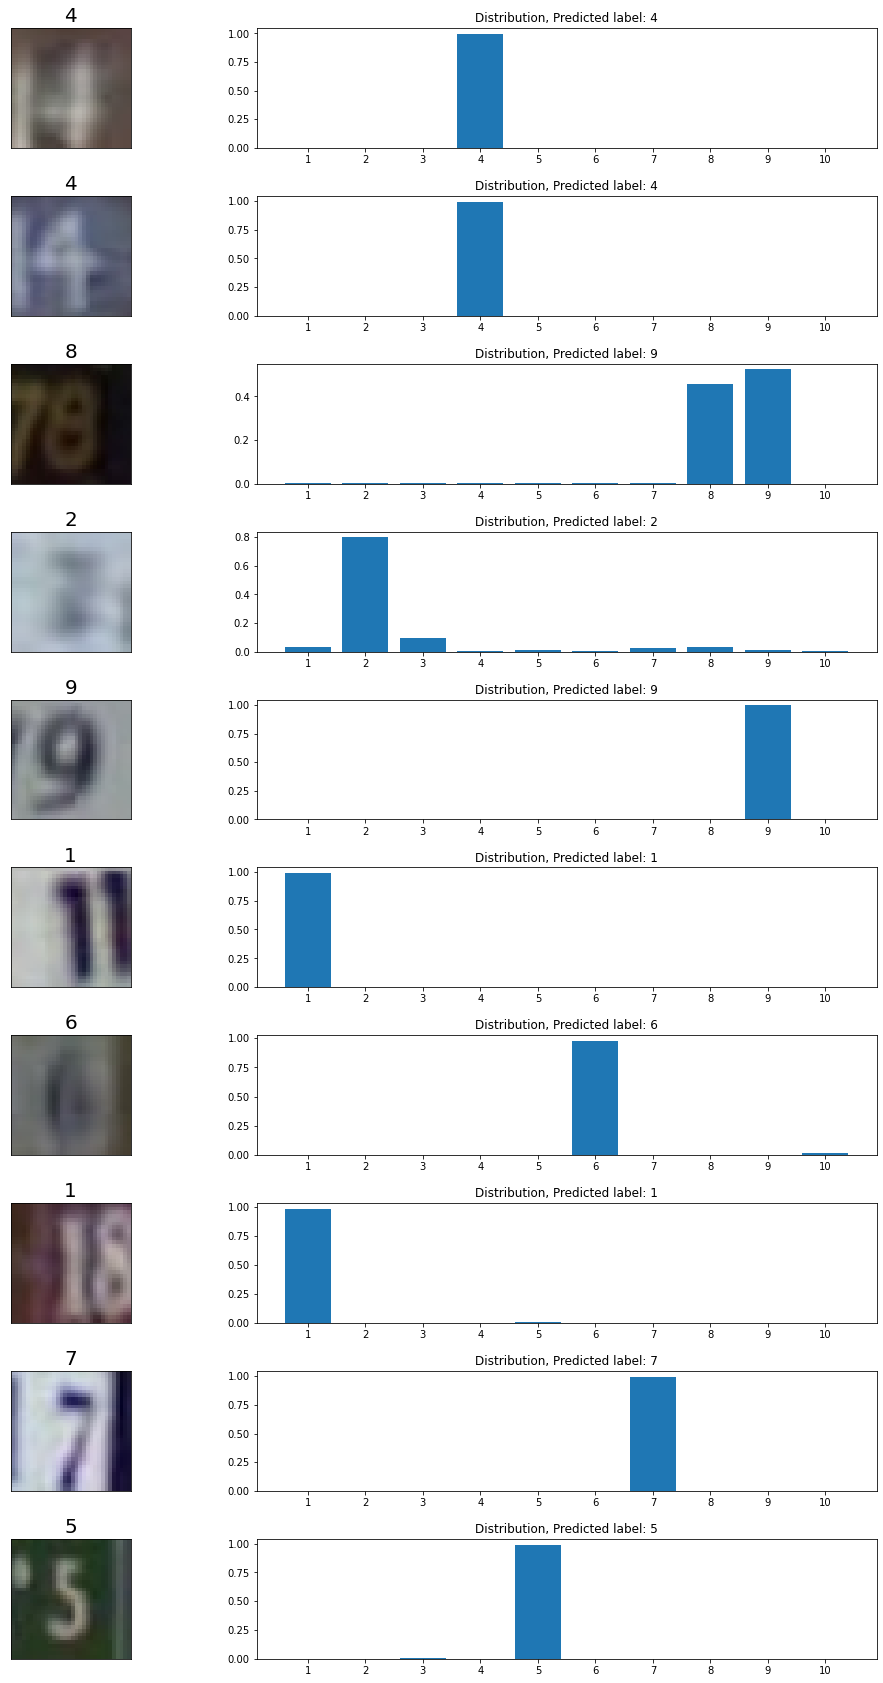

In [ ]:
show_img_predictions(num=10, predictions='cnn')

<BarContainer object of 10 artists>

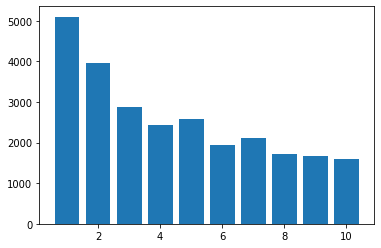

In [ ]:
cnn_dist = collections.Counter(cnn_results)

plt.bar(cnn_dist.keys(), cnn_dist.values(), align='center')

## Bonus: True distribution

<BarContainer object of 10 artists>

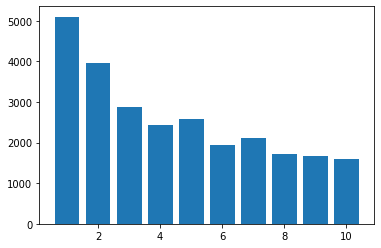

In [ ]:
# Bonus: True dist
true_dist = collections.Counter(test['y'].reshape(-1))
plt.bar(cnn_dist.keys(), cnn_dist.values(), align='center')

### CNN did relatively well!